## ML competition

_Marilyn, Shiva, Olivier_

In [2]:
%load_ext autoreload
%autoreload 2

In [34]:
# Setup chunk

import time

# Custom utils
from utils import *

# Data wrangling
import pandas as pd
import numpy as np

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Text sanitization
import re
import nltk
from nltk.stem.snowball import SnowballStemmer

try:
    # Avoid error if you don't have the resource
    stopwords = nltk.corpus.stopwords.words("english")
except LookupError:
    nltk.download("stopwords")
    stopwords = nltk.corpus.stopwords.words("english")
    
stemmer = SnowballStemmer(language="english")

# Lang detection
#import langid
#from langid.langid import LanguageIdentifier, model
#identifier = LanguageIdentifier.from_modelstring(model, norm_probs=True)

# Misc
from tqdm import tqdm
tqdm.pandas()

# Define the seed for reproducibility
SEED = 31415
# Define n_jobs
JOBS = 7

In [4]:
# Scikit time
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

from sklearn.feature_extraction.text import (
    CountVectorizer, 
    TfidfTransformer, 
    TfidfVectorizer
)
from sklearn.pipeline import Pipeline, make_pipeline


from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    KFold, 
    cross_val_score
)

from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    confusion_matrix
)

In [5]:
df = pd.read_csv("data/MLUnige2021_train.csv")

### 1. EDA
Small EDA to check a bit the data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280000 entries, 0 to 1279999
Data columns (total 7 columns):
Id           1280000 non-null int64
emotion      1280000 non-null int64
tweet_id     1280000 non-null int64
date         1280000 non-null object
lyx_query    1280000 non-null object
user         1280000 non-null object
text         1280000 non-null object
dtypes: int64(3), object(4)
memory usage: 68.4+ MB


More than a million entries. What is `lyx_query`? 

In [7]:
df["lyx_query"].head()
df["lyx_query"].unique()

array(['NO_QUERY'], dtype=object)

Welp only `"NO_QUERY"` so we can drop it. 

In [8]:
df["tweet_id"]

0          2063391019
1          2000525676
2          2218180611
3          2190269101
4          2069249490
              ...    
1279995    1835296397
1279996    2226720395
1279997    1962176213
1279998    1976894947
1279999    1563596981
Name: tweet_id, Length: 1280000, dtype: int64

Those are old tweets

In [9]:
df["date"]

0          Sun Jun 07 02:28:13 PDT 2009
1          Mon Jun 01 22:18:53 PDT 2009
2          Wed Jun 17 22:01:38 PDT 2009
3          Tue Jun 16 02:14:47 PDT 2009
4          Sun Jun 07 15:31:58 PDT 2009
                       ...             
1279995    Mon May 18 05:39:18 PDT 2009
1279996    Thu Jun 18 12:18:05 PDT 2009
1279997    Fri May 29 10:38:30 PDT 2009
1279998    Sat May 30 19:28:13 PDT 2009
1279999    Sun Apr 19 23:27:25 PDT 2009
Name: date, Length: 1280000, dtype: object

Indeed they are.

In [10]:
len(df["user"].unique())

574114

Lots of different users. If we had only like 1000s of users, we could have looked for some pattern (user X is only positive ...).

In [11]:
df.loc[0, ["emotion", "text"]]

emotion                                                    1
text       @BreeMe more time to play with you BlackBerry ...
Name: 0, dtype: object

In [12]:
df["emotion"].unique()

array([1, 0])

In [13]:
df[df["emotion"]==1].shape[0] - df[df["emotion"]==0].shape[0]

236

Perfectly balanced dataset (236 diff between the 2 classes).

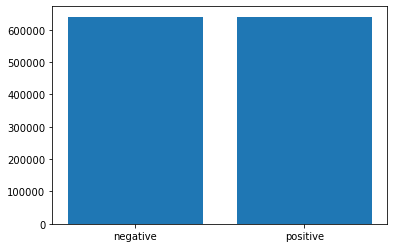

In [14]:
fig, ax = plt.subplots()
ax.bar(["negative", "positive"], [df[df["emotion"]==0].shape[0], df[df["emotion"]==1].shape[0]])
plt.show()

Let's also check the language of the tweets (all eng or also others?). For that, 

In [15]:
df_samp = df.sample(150_000) #Total df takes 1h to run

# Commented because we don't want it to run everytime
#df_samp["lang"] = df_samp["text"].progress_apply(lang_detect)
#df_samp["lang"].unique()
#df_samp[~(df_samp["lang"] == "en")].count()

Only 15k tweets which are not detected as english in our 150k sample. By checking some of the tweets, most are english, but the language detector surely has some trouble with some very short tweets containing one or more foreign words.--> consider all as english!

## 2. Strategy

1. Preprocess the text
    1. remove punctuation marks
    2. remove stopwords (en)
    3. stem or lemmatize the words
    
    
2. take a sample of our whole dataset (200k?) to do our preliminary test. We can't do cross validation on the whole dataset.

3. Begin to fit the models. 
    1. Pipeline with TfidfTransformer (or the other one I don't remember the name)
    2. BerNB
    3. LogisticRegression
    4. RidgeClassifier
    5. SGDClassifier
    6. SVC
    7. RandomForestClassifier
    8. DecisionTreeClassifier
    9. KNeighborsClassifier
    10. LDA? QDA?
4. Select a few of the best models, CV with bigger dataset
5. ...

## Misc

- Should pay attention to some special chars which were not removed: "I \&lt;3 you" (#2204), at first just remove it, but we could try investigate that

In [153]:
df[df["text"].str.contains("&lt;3")].count()
(df[df["text"].str.contains("&lt;3")].loc[:, "emotion"] == 1).sum()

7082

10635 tweets have that, don't think it's worth it. And out of those, only 7082 are positive. It's not even as sure as that.

# 1. Preprocessing

In [13]:
# Some special strings to test 
txt1 = "Hello @Shiva and @Marilyn! https://hello.ch 12334 #corona ..."
print("Sanitized:", sanitize(txt1))

Sanitized: hello shiva marilyn corona 


In [17]:
# As a test, sanitize the subsample
#df_samp["sanitized"] = df_samp["text"].progress_apply(sanitize)
df_samp.head() #seems good

,Id,emotion,tweet_id,date,lyx_query,user,text
1168603,1168603,1,2001190216,Tue Jun 02 00:06:31 PDT 2009,NO_QUERY,bonnietsang,@AdamandEveWed Thanks! Are you going to Sprink...
1017561,1017561,0,2062884238,Sun Jun 07 00:37:25 PDT 2009,NO_QUERY,TennealMaree,i want the sims 3 stupid indian man killed my...
651245,651245,0,2049892047,Fri Jun 05 17:41:12 PDT 2009,NO_QUERY,sssallypau,carnival was fun! scratched up knees isn't
950878,950878,0,2235937462,Fri Jun 19 02:27:03 PDT 2009,NO_QUERY,nautynature,@aaroncarter7 i called u a king and legend and...
688158,688158,1,2067742010,Sun Jun 07 12:52:48 PDT 2009,NO_QUERY,xoAlexHeartsxo,"@David_DB I'm great thanks, just heading to be..."


In [22]:
try:
    #If you have an error with sanitized-rec.pkl try to take sanitized.pkl
    df_san = pd.read_pickle("./data/sanitized-rec.pkl")
except FileNotFoundError:
    print("No pickle file found, sanitizing existing df")
    
    # Sanitize whole dataset
    df_san = df.copy()
    df_san["sanitized"] = df["text"].progress_apply(sanitize)

    # Export it to pickle so we don't have to redo it
    df_san.to_pickle("./data/sanitized.pkl")

In [23]:
print(df_san.shape)
df_san.head()

(1280000, 8)


,Id,emotion,tweet_id,date,lyx_query,user,text,sanitized
0,0,1,2063391019,Sun Jun 07 02:28:13 PDT 2009,NO_QUERY,BerryGurus,@BreeMe more time to play with you BlackBerry ...,breem time play blackberri
1,1,0,2000525676,Mon Jun 01 22:18:53 PDT 2009,NO_QUERY,peterlanoie,Failed attempt at booting to a flash drive. Th...,fail attempt boot flash drive fail attempt swi...
2,2,0,2218180611,Wed Jun 17 22:01:38 PDT 2009,NO_QUERY,will_tooker,@msproductions Well ain't that the truth. Wher...,msproduct well truth damn auto lock disabl go...
3,3,1,2190269101,Tue Jun 16 02:14:47 PDT 2009,NO_QUERY,sammutimer,@Meaghery cheers Craig - that was really sweet...,meagheri cheer craig realli sweet repli pump
4,4,0,2069249490,Sun Jun 07 15:31:58 PDT 2009,NO_QUERY,ohaijustin,I was reading the tweets that got send to me w...,read tweet got send lie phone face drop amp hi...


In [24]:
print("Before sanitizing", df['text'].apply(lambda x: len(x.split(' '))).sum())
print("After sanitizing", df_san['sanitized'].apply(lambda x: len(x.split(' '))).sum())

Before sanitizing 18398298
After sanitizing 10730388


Just to check, we see that before sanitizing, we had 18'398'298 words. We were able to halve it to 9'575'942 by sanitization and stemming our tweets.

Before fitting our models, we also take a subsample to be able to compute them faster.

In [30]:
df_sub = df_san.sample(frac=1, random_state=SEED)

# To check reproducibility
print("First Id", df_sub["Id"].iloc[0])
print("Last Id", df_sub["Id"].iloc[-1])
print("Length", df_sub.shape[0])

First Id 423388
Last Id 813069
Length 1280000


# 2. Fitting

Now that we have a subsample (10%) of our cleaned data, we can try to fit some models to see what it gives us. We also define a standard 10 kfolds which we will use for our cross-validation. 

Just as a note to justify the 10% choice for our sample. The bernoulli classifier below achieves, with default settings, an accuracy score of `76.37%` when using the whole dataset. For 10% of the dataset, the accuracy drops to `75.24%`. A 1% drop in accuracy for 10 times less computation time seems worth it.

In [31]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(df_sub["sanitized"], df_sub["emotion"], 
                                                    test_size=0.2, shuffle=True, random_state=SEED)

#only 4 folds because I have 4 cores, just to test
folds = KFold(n_splits=4, shuffle=True, random_state=SEED)

In [32]:
# Sanity check
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (1024000,)
X_test:  (256000,)
y_train:  (1024000,)
y_test:  (256000,)


First model we will try is the `BernoulliNB` since we have binary data. 

In [33]:
berNB = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("clf", BernoulliNB()),
    ]
)

start = time.time()

CV_ber = cross_val_score(
    berNB, X_train, y_train, scoring="accuracy", cv=folds, n_jobs=JOBS
)

berNB.fit(X_train, y_train)
y_pred = berNB.predict(X_test)
score = accuracy_score(y_test, y_pred)
print(f"Time {time.time() - start}")
print(f"Mean CV accuracy: {np.mean(CV_ber)}")
print(f"Test accuracy: {score}")

"""
Whole dataset:
Time 21.568854093551636
Mean CV accuracy: 0.7639306640625
Test accuracy: 0.76375390625

10% sample:
Time 2.146036386489868
Mean CV accuracy: 0.7483203125
Test accuracy: 0.7523828125
"""

Time 45.136425495147705
Mean CV accuracy: 0.7648857421875
Test accuracy: 0.76526953125


'\nWhole dataset:\nTime 21.568854093551636\nMean CV accuracy: 0.7639306640625\nTest accuracy: 0.76375390625\n\n10% sample:\nTime 2.146036386489868\nMean CV accuracy: 0.7483203125\nTest accuracy: 0.7523828125\n'

Without any paramter tuning, we got 75% with the naive Bayes Bernoulli classifier.
Baseline is `0.77309`. 

No matter the alpha, we don't seem to get higher than 0.75. BernoulliNB is not the best model here.
Instead of having to write the same for every model, let's try to automatize the testing just by specifying the model and the parameters grid.

In [35]:

models = [LogisticRegression(warm_start=True)]
models = [SGDClassifier(warm_start=True)]
models = [BaggingClassifier(warm_start=True)]
models = [RandomForestClassifier(warm_start=True)]
models = [BaggingClassifier(warm_start=True)]
models = [SVC()]
models = [LinearSVC()]
models = [RidgeClassifier()]
models = [BernoulliNB()]

params_tfid = {
    "tfidfvectorizer__norm": ["l2"],
    "tfidfvectorizer__analyzer": ["word"],
    "tfidfvectorizer__ngram_range": [(1,2)],
    "tfidfvectorizer__max_df": [0.7],
    "tfidfvectorizer__min_df": [3],
    "tfidfvectorizer__binary": [True, False],
    #"tfidfvectorizer__use_idf": [True, False],
    #"tfidfvectorizer__smooth_idf": [True, False],
    #"tfidfvectorizer__sublinear_tf": [True, False]
}

params = {
    "bernoullinb": {
        "bernoullinb__alpha": [7.5],
        "bernoullinb__fit_prior": [False, True],
    },
    "ridgeclassifier": {
        "ridgeclassifier__alpha": np.linspace(1e-5, 10, 5),
        "ridgeclassifier__class_weight": ["balanced", None],
        "ridgeclassifier__normalize": [False, True],
        
    },
    "logisticregression": {
        #"logisticregression__penalty": ["l1", "l2", "elasticnet"],
        "logisticregression__penalty": ["l1"],
        #"logisticregression__dual": [False, True], try with liblinear
        "logisticregression__C": 10**np.linspace(-3, -0.001, 4),
        #"logisticregression__C": [1e-1],
        "logisticregression__random_state": [SEED],
        #"logisticregression__solver": ["newton-cg", "lbfgs", "saga"],
        "logisticregression__solver": ["saga"],
        #"logisticregression__l1_ratio": np.linspace(0.1, 0.9, 5),
    },
    "sgdclassifier": {
        "sgdclassifier__random_state": [SEED],
        "sgdclassifier__loss": ["modified_huber"],
        "sgdclassifier__alpha": 10**np.linspace(-3, -0.001, 4),
    },
    "baggingclassifier": {
        "baggingclassifier__random_state": [SEED],
        "baggingclassifier__n_estimators": [30],
        "baggingclassifier__max_samples": [0.05],
        "baggingclassifier__max_features": [0.5],
        
    },
    "randomforestclassifier": {
        "randomforestclassifier__random_state": [SEED],
    },
    "svc": {
        "svc__random_state": [SEED],
    },
    "linearsvc": {
        "linearsvc__random_state": [SEED],
        "linearsvc__loss": ["squared_hinge"],
        "linearsvc__penalty": ["l2"],
        "linearsvc__max_iter": [1000],
        "linearsvc__dual": [False],
        "linearsvc__C": np.linspace(0.01, 0.2, 10),
        "linearsvc__class_weight": ["balanced"],
    }
}

# If we also want to gridsearch the different Tfidf params
for k, v in params_tfid.items():
    params["bernoullinb"][k] = v
    #Easier if we comment above
    pass

pipes = []

# Also check what we can do with the TfidfVectorizer parameters
for model in models:
    pipe = make_pipeline(TfidfVectorizer(), model)
    pipes.append(pipe)
    
    # Will use that once we have the best params
    #pipe.set_params(**params[pipe.steps[1][0]])

# Initialize empty dictionary
reports = {}

In [36]:
10**np.linspace(-5, 0.099, 10)

array([1.00000000e-05, 3.68600191e-05, 1.35866101e-04, 5.00802706e-04,
       1.84595973e-03, 6.80421108e-03, 2.50803350e-02, 9.24461627e-02,
       3.40756732e-01, 1.25602996e+00])

In [140]:
# Fit each different pipeline

for pipe in pipes:
    print(pipe.steps[1][0])
    start = time.time()
    
    gridsearch = GridSearchCV(pipe, params[pipe.steps[1][0]], scoring="accuracy", cv=folds, n_jobs=JOBS, verbose=3)
    gridsearch.fit(X_train, y_train)
    y_pred = gridsearch.predict(X_test)
    
    score = accuracy_score(y_test, y_pred)
    resdf = pd.DataFrame(gridsearch.cv_results_)
    
    reports[pipe.steps[1][0]] = classification_report(y_test, y_pred)
    
    print(f"Time {time.time() - start}s")
    #print(resdf[resdf["rank_test_score"] == 1])
    print(f"Test accuracy: {score}")
    

bernoullinb
Fitting 4 folds for each of 2 candidates, totalling 8 fits
Time 3.202148675918579s
Test accuracy: 0.7553125


In [141]:
resdf.sort_values(by=["rank_test_score"]) 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bernoullinb__alpha,param_bernoullinb__fit_prior,param_tfidfvectorizer__analyzer,param_tfidfvectorizer__norm,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.686249,0.014220,0.224001,0.020384,7.5,False,word,l2,"{'bernoullinb__alpha': 7.5, 'bernoullinb__fit_...",0.749570,0.753828,0.753437,0.756953,0.753447,0.00262,1
1,0.663750,0.016436,0.193498,0.006983,7.5,True,word,l2,"{'bernoullinb__alpha': 7.5, 'bernoullinb__fit_...",0.749844,0.754023,0.752734,0.756563,0.753291,0.00242,2


### Summary

Linear models: <br>
BernoulliNB: 0.76 <br>
LogisticRegression: <br>
    l2 - 0.76 <br>
    l2, C range - 0.76 <br>
    elasticnet, C range, l1_ratio range - 0.75 <br>
    l1, C=0.1 - 0.74 <br>
    l1, C range - 0.76 <br>
sgdclassifier: <br>
    all default - 0.75 <br>
    modified_huber - 0.75 <br>
ridgeclassifier: <br>
    alpha=7.5, class_weight=balanced, normalize=False -> 0.76
    
Linear models seem not to perform better than around 0.75. Let's go to ensembles.

Ensemble: <br>
RandomForestClassifier: <br>
    max_samples 0.001 - 0.59 <br>
    max_samples 0.1 - 0.71 <br>
    max_samples 0.8 - 0.73 <br>
    max_samples 0.01, n_estimators 40 - 0.71 <br>
    max_samples 0.01, n_estimators 20 - 0.68 <br>
    max_samples 0.01, n_estimators 100 - 0.72 <br>
    max_samples 0.1, n_estimators 50 - 0.74 <br>
    max_samples 0.5, n_estimators 70 - 0.75 <br>
    max_samples 0.1, n_estimators 150 - 0.75 <br>

BaggingClassifier: <br>
    max_samples 0.01, n_estimators 100 - 0.70 <br>
    max_samples 0.1, n_estimators 10 - 0.72 <br>
    max_samples 0.05, n_estimators 30 - 0.72 <br>
    max_samples 0.05, n_estimators 30, max_features 0.5 - 0.72 <br>
    
SVC: -> not fast enough
 
LinearSVC: <br>
default: 0.75 -> really fast! <br>
squared_hinge + dual=False + C=0.1 -> 0.76 <br>
squared_hinge + dual=False + C=0.1 + class_weight=balanced -> 0.76


    

No matter the classifier, we don't seem to go above 76%. Look into the data to see if we can see something.
-> delete very short tweets?
-> lemmatization?

Maybe deleted too much noise during preprocessing, only remove stopwords? (+URLs?)